In [1]:
import numpy as np
import csv
from scipy.io import wavfile as wav
from scipy.fftpack import fft
from random import randint
import librosa
from librosa import display
from librosa import feature
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

FileNames = {"train":"ml-fmi-23-2020//train.txt", "valid":"ml-fmi-23-2020//validation.txt", "test":"ml-fmi-23-2020//test.txt", "ex":"ml-fmi-23-2020//sample_submission.txt","pred":"ml-fmi-23-2020//predictions.txt"}

AudioFolders = {"train":"ml-fmi-23-2020//audio//train//", "valid":"ml-fmi-23-2020//audio//validation//", "test":"ml-fmi-23-2020//audio//test//"}

SpectogramFolders = {"train":"ml-fmi-23-2020//spectogram//train//", "valid":"ml-fmi-23-2020//spectogram//validation//", "test":"ml-fmi-23-2020//spectogram//test//"}

def readCsv (fileName, hasLables):
    data = []
    with open(fileName, "r", newline='\n') as csvfile:
        for row in csv.reader(csvfile, delimiter=','):
            data.extend(row)
    if hasLables:
        data = np.transpose(np.array(data).reshape((len(data)//2, 2))) 
    else:
        data = np.array(data)
    return data
def writeCsv (data, labels, fileName = FileNames['pred']):
    with open(fileName, "w", newline='\n') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['name', 'label'])
        for row in np.transpose([data, labels]):
            writer.writerow(row)

def audioToSpectograms (folderName, dataNames):
    i = 0
    for dataName in dataNames:
        i += 1
        if i % 100 == 0:
            print (i, '/', len(dataNames))
        audio, sr = librosa.load(AudioFolders[folderName]+dataName)
        audio_db  = librosa.amplitude_to_db(abs(librosa.stft(audio)))
        librosa.display.specshow(audio_db, sr=sr, cmap='gray')
        plt.savefig(SpectogramFolders[folderName]+dataName[:-3]+'png', bbox_inches='tight', pad_inches=0)
    print ('Done with', folderName)

def getData (folderName, dataNames):
    data = []
    for dataName in dataNames:
        audio = librosa.load(AudioFolders[folderName]+dataName)[0]
        data.append(librosa.amplitude_to_db(abs(librosa.stft(audio))).reshape(-1))
        # data.append(np.abs(fft(wav.read(AudioFolders[folderName]+dataName)[1])))
    return np.array(data)

In [2]:
# the len of each audio file is 16000 
train_data_name, train_labels = readCsv(FileNames['train'], hasLables=True)
valid_data_name, valid_labels = readCsv(FileNames['valid'], hasLables=True)
test_data_name                = readCsv(FileNames['test'],  hasLables=False)
# writeCsv(train_data, train_labels)

In [4]:
# train_data = getData('train', train_data_name)
# valid_data = getData('valid', valid_data_name)
# test_data  = getData('test',  test_data_name)

In [5]:
mi = min([train_data.min(), valid_data.min(), test_data.min()])
ma = max([train_data.max(), valid_data.max(), test_data.max()])
mi, ma

(-57.697765, 50.504)

In [6]:
train_fit = (train_data - mi) / (ma-mi)
valid_fit = (valid_data - mi) / (ma-mi)
test_fit  = (test_data  - mi) / (ma-mi)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(15, metric='l1', weights='distance')
knn.fit(train_fit, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='l1',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')

In [8]:
valid_pred_knn = knn.predict(valid_fit)

In [9]:
good_knn = np.argwhere(valid_pred_knn==valid_labels).reshape(-1)
print (len(good_knn)/len(valid_pred_knn))
confusion_matrix(valid_pred_knn, valid_labels)

0.573


array([[178, 133],
       [294, 395]], dtype=int64)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(15, metric='l1')
knn.fit(np.concatenate ((train_fit, valid_fit)), np.concatenate ((train_labels, valid_labels)))

In [ ]:
pred_knn = knn.predict(test_fit)

In [ ]:
writeCsv(test_data_name, pred_knn)

In [18]:
a = [1, 2]
b = [3, 4]
for i, j in zip(a, b):
    print (i, j)

1 3
2 4


In [ ]:
from sklearn.svm import SVC
svm = SVC(1, 'linear')
svm.fit(train_data, train_labels)

In [ ]:
valid_pred_svm = svm.predict(valid_data)

In [ ]:
good = np.argwhere(valid_pred_svm==valid_labels)
print (len(good)/len(valid_pred_svm))
confusion_matrix(valid_pred_svm, valid_labels)

['a', 'b', 'd', 'f']

In [ ]:
from sklearn.svm import SVC
svm = SVC(1, 'linear')
svm.fit(np.concatenate ((train_data, valid_data)), np.concatenate ((train_labels, valid_labels)))

In [ ]:
pred_svm = svm.predict(test_data)

In [ ]:
writeCsv(test_data_name, pred_svm)

In [14]:
from scipy.io import wavfile
def plotdata (dataLen = 10, t=None):
    if t not in ['0', '1', None]:
        raise Exception ("UnknownType")
    for i in range (dataLen):
        curr = randint(0, len(train_data_name)-1)
        if t is not None:
            while train_labels[curr] != t:
                curr = randint(0, len(train_data_name)-1)
        
        data = wavfile.read(AudioFolders['train']+train_data_name[curr])[1]

        absdata = np.abs(data)
        sorteddata = np.sort(absdata)
        floatdata = data.astype(np.float)

        fig, axis = plt.subplots(2,3)
        plt.subplots_adjust(wspace=1)
        axis[0,1].set_title (str(i) + 'Audio signal Data in time ' + str(train_data_name[curr]) + ' - ' + ("Mask" if train_labels[curr]=='1' else "NoMask"),size=16)

        axis[0,0].plot(data)
        axis[1,0].hist(data)
        axis[0,1].plot(absdata)
        axis[1,1].hist(absdata)
        axis[0,2].plot(sorteddata)
        axis[1,2].hist(sorteddata)

        plt.show()

def dataHist (audioName, folder, show=True, isAbs=False):
    data = []
    for name in audioName:
        data.extend(wavfile.read(AudioFolders[folder]+name)[1])
    if isAbs:
        data = np.abs(data)
    plt.hist(data)
    plt.title('All Hist for ' + folder,size=16)
    if show:
        plt.show()
    return data

def dataHistAll (audioNames, folderKeys, isAbs=False):
    data = []
    for i in range (len(audioNames)):
        data.extend(dataHist(audioNames[i], folderKeys[i], isAbs=isAbs))
    plt.hist(data)
    plt.title('Hist over all',size=16)
    plt.show()

def spectrogram (dataLen = 10, t=None):
    if t not in ['0', '1', None]:
        raise Exception ("UnknownType")
    for i in range (dataLen):
        curr = randint(0, len(train_data_name)-1)
        if t is not None:
            while train_labels[curr] != t:
                curr = randint(0, len(train_data_name)-1)
        
        x , sr = librosa.load(AudioFolders['train']+train_data_name[curr])

        # plt.figure(figsize=(14, 5))
        # librosa.display.waveplot(x, sr=sr)

        Xdb = librosa.amplitude_to_db(abs(librosa.stft(x)))
        # plt.figure(figsize=(14, 5))
        librosa.display.specshow(Xdb, sr=sr, cmap='gray')#, x_axis='time', y_axis='log')
        plt.savefig('test.png', bbox_inches='tight', pad_inches=0)
        # plt.colorbar()

        # # plt.title(str(i) + '. Audio signal Data in time ' + str(curr) + ' - ' + ("Mask" if train_labels[curr]=='1' else "NoMask"),size=16)
        # # display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
        # # plt.colorbar()
        # # plt.show()
        # plt.figure(figsize=(14, 5))
        # # plt.title(str(i) + '. Audio signal Data in time ' + str(curr) + ' - ' + ("Mask" if train_labels[curr]=='1' else "NoMask"),size=16)
        # display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
        # # plt.colorbar()
        # # plt.savefig('test.png')
        # plt.show()

# dataHistAll ([train_data, valid_data, test_data], list(AudioFolders.keys()))
# plotdata()

In [47]:
train_data_name[train_mask].reshape(-1)

array(['102333.wav', '103981.wav', '105528.wav', ..., '103544.wav',
       '104132.wav', '106837.wav'], dtype='<U10')

In [44]:
wavfile.read(AudioFolders['train']+train_data_name[train_mask[0]])[1]

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U30') dtype('<U30') dtype('<U30')

In [42]:
dataHist(train_data_name[train_mask], 'train')

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U30') dtype('<U30') dtype('<U30')

In [ ]:
wavfile.read(AudioFolders[folder]+name

In [28]:
train_mask = np.argwhere(train_labels=='1')
train_nomask = np.argwhere(train_labels=='0')

In [29]:
valid_mask = np.argwhere(valid_labels=='1')
valid_nomask = np.argwhere(valid_labels=='0')

In [30]:
train_mask.shape, train_nomask.shape, valid_mask.shape, valid_nomask.shape

((4076, 1), (3924, 1), (528, 1), (472, 1))

In [ ]:
train_data_name[train_mask], valid_data_name[valid_mask]

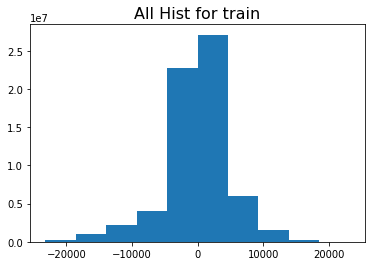

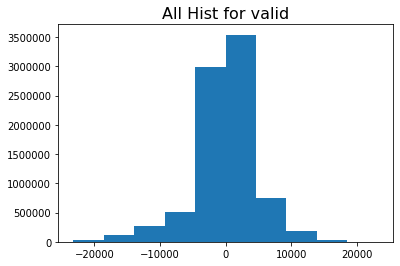

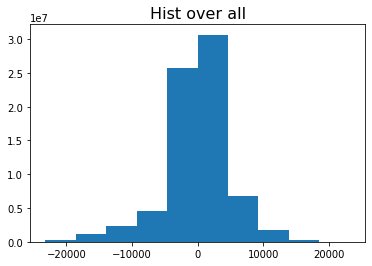

In [51]:
dataHistAll ([train_data_name[train_mask].reshape(-1), valid_data_name[valid_mask].reshape(-1)], ['train', 'valid'])

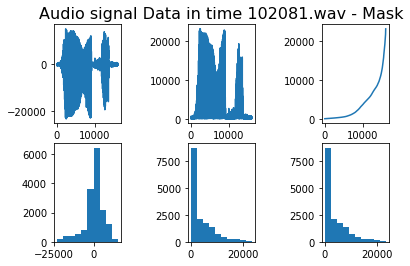

In [21]:
audioNames, folderKeys, isAbs=):
data = []
for i in range (len(audioNames)):
    data.extend(dataHist(audioNames[i], folderKeys[i]))
plt.hist(data)
plt.title('Hist over all',size=16)
plt.show()

In [23]:
plt.savefig ('plots//1')

<Figure size 432x288 with 0 Axes>

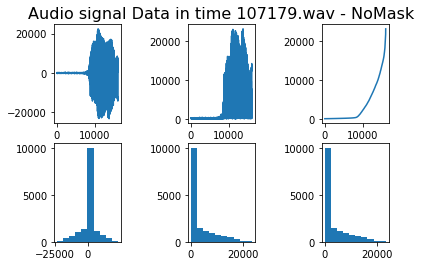

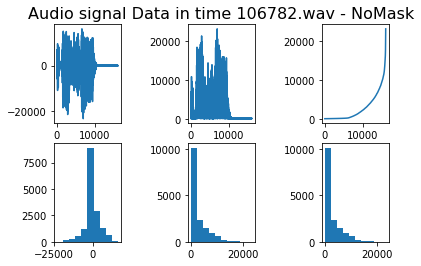

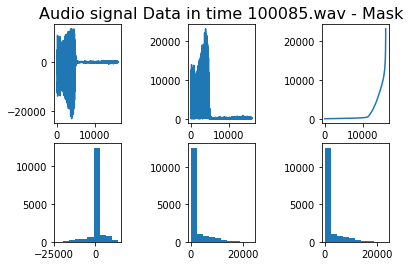

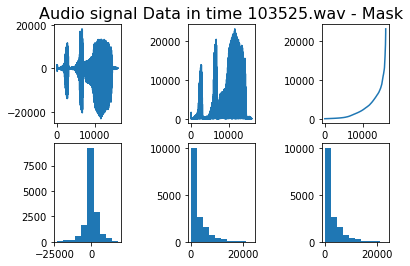

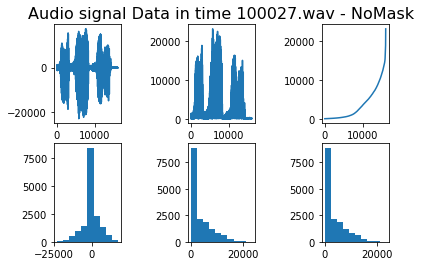

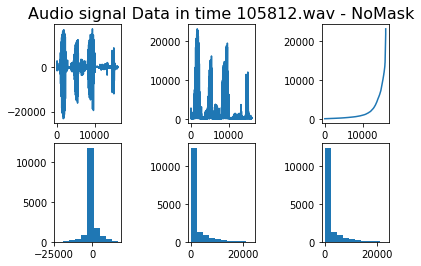

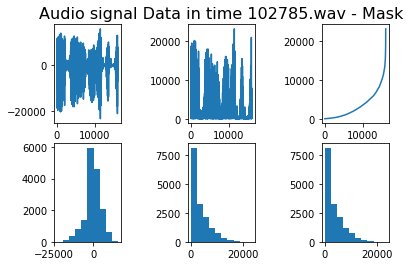

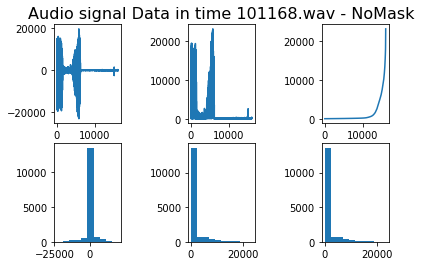

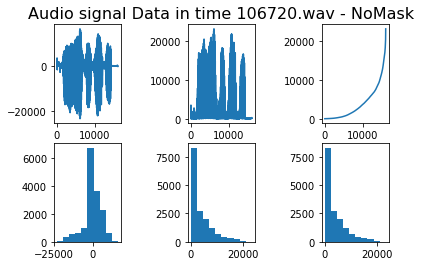

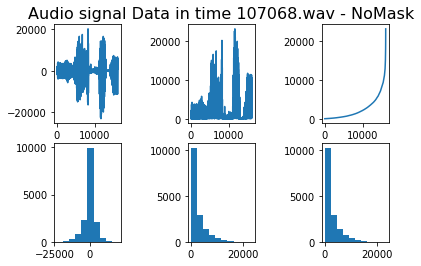

In [15]:
def dataHistAll (audioNames, folderKeys, isAbs=False):
    data = []
    for i in range (len(audioNames)):
        data.extend(dataHist(audioNames[i], folderKeys[i], isAbs=isAbs))
    plt.hist(data)
    plt.title('Hist over all',size=16)
    plt.show()


In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_data, train_labels)
nb.score(valid_data, valid_labels)

In [ ]:
confusion_matrix(nb.predict(valid_data), valid_labels)

In [ ]:
writeCsv(test_data_name, nb.predict(test_data))

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# lda.fit(train_data, train_labels)
# valid_pred_lda = lda.predict(valid_data)
# good_lda = np.argwhere(valid_pred_lda==valid_labels)
# print (len(good_lda)/len(valid_pred_lda)) # 0.484
# confusion_matrix(valid_pred_lda, valid_labels)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(5)
knn.fit(train_data, train_labels)
# knn.score(valid_data, valid_labels)
valid_pred_knn = knn.predict(valid_data)
good_knn = np.argwhere(valid_pred_knn==valid_labels).reshape(-1)
print (len(good_knn)/len(valid_pred_knn))

In [ ]:
good = np.argwhere(valid_pred==valid_labels).reshape(-1)
print (len(good)/len(valid_pred))

In [ ]:
confusion_matrix(valid_pred, valid_labels)

In [ ]:
writeCsv(test_data_name, knn.predict(test_data))

In [ ]:
from sklearn.svm import SVC
svm = SVC() # 1, 'linear')
svm.fit(train_data, train_labels)
valid_pred_svm = svm.predict(valid_data)
good = np.argwhere(valid_pred_svm==valid_labels)
print (len(good)/len(valid_pred_svm))

In [ ]:
confusion_matrix(valid_pred_svm, valid_labels)

In [ ]:
writeCsv(test_data_name, svc.predict(test_data))

In [ ]:
import matplotlib.pyplot as plt
t = wavfile.read(AudioFolders['train']+train_data_name[randint(0, len(train_data_name)-1)])[1]#.astype(np.float)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
np.transpose([freq, sp.real])

plt.plot(freq, sp, freq, sp.imag)
plt.show()

In [ ]:
data = wavfile.read(AudioFolders['train']+train_data[randint(0, len(train_data)-1)])[1].astype(np.float)
print(librosa.core.stft(data))
plt.plot(librosa.core.stft(data))
plt.show()
print(librosa.feature.melspectrogram(data))
plt.plot(librosa.feature.melspectrogram(data))
plt.show()


In [ ]:
print(librosa.core.stft(data))
plt.plot(librosa.core.stft(data))
plt.show()
print(librosa.feature.melspectrogram(data))
plt.plot(librosa.feature.melspectrogram(data))
plt.show()